In [ ]:
import json
import pandas as pd
from pymongo import MongoClient

In [ ]:
client = MongoClient('localhost', 27017)
db = client.steamspy

In [ ]:
data = pd.DataFrame(list(db.clean.find()))

In [ ]:
data.drop(columns = "_id", inplace = True) #drop _id column

In [ ]:
gamefeatures= pd.read_csv("gamefeatures.csv")

In [ ]:
gamefeatures = gamefeatures.rename(columns = {'QueryID':'id'})

In [ ]:
gamefeatures = gamefeatures.drop(columns = ['ResponseID', 'QueryName', 'ResponseName', 'DemoCount', 'DeveloperCount', 'DLCCount',
                            'MovieCount', 'PackageCount', 'PublisherCount', 'ScreenshotCount',
                            'SteamSpyOwners', 'SteamSpyOwnersVariance', 'SteamSpyPlayersEstimate',
                            'SteamSpyPlayersVariance', 'AchievementHighlightedCount', 'IsFree', 'FreeVerAvail',
                            'PurchaseAvail', 'PCReqsHaveMin', 'PCReqsHaveRec', 'LinuxReqsHaveMin', 
                            'LinuxReqsHaveRec', 'MacReqsHaveMin', 'MacReqsHaveRec', 'CategorySinglePlayer',
                            'CategoryMultiplayer', 'CategoryCoop', 'CategoryMMO', 'CategoryInAppPurchase',
                            'CategoryIncludeSrcSDK', 'CategoryIncludeLevelEditor', 'CategoryVRSupport', 
                            'GenreIsNonGame', 'GenreIsIndie', 'GenreIsAction', 'GenreIsAdventure', 'GenreIsCasual',
                            'GenreIsStrategy', 'GenreIsRPG', 'GenreIsSimulation', 'GenreIsEarlyAccess', 
                            'GenreIsFreeToPlay', 'GenreIsSports', 'GenreIsRacing', 'GenreIsMassivelyMultiplayer', 
                            'PriceCurrency', 'PriceInitial', 'PriceFinal', 'SupportEmail', 'SupportURL', 
                            'AboutText', 'Background', 'ShortDescrip', 'DetailedDescrip', 'DRMNotice', 
                            'ExtUserAcctNotice', 'HeaderImage', 'LegalNotice', 'Reviews', 'SupportedLanguages',
                            'Website', 'PCMinReqsText', 'PCRecReqsText', 'LinuxMinReqsText', 'LinuxRecReqsText',
                            'MacMinReqsText', 'MacRecReqsText']) #dropping useless columns

In [ ]:
gamefeatures = gamefeatures.rename(columns = {'id':'appid'}) #match datas id column

In [ ]:
df = pd.merge(gamefeatures, data, on=['appid'], how='left')

In [ ]:
merged = db.merged

In [ ]:
records = json.loads(df.T.to_json()).values() #store the merged df in mongo
merged.insert(records)

In [ ]:
free = data[data['Genres'].apply(lambda x: 'Free' in x)] 
paid = data[data['Genres'].apply(lambda x: 'Free' not in x)] 

In [ ]:
freeOwnersL = free['llOwners'].sum()
paidOwnersL = paid['llOwners'].sum()
freeOwnersU = free['ulOwners'].sum()
paidOwnersU = paid['ulOwners'].sum()

In [ ]:
dfFree = pd.DataFrame({'Type':['Free', 'Paid'], 'Lower Limit Owners':[freeOwnersL, paidOwnersL], 'Upper Limit Owners':
                      [freeOwnersU, paidOwnersU]})

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
ax = dfFree.plot.bar(x = 'Type',rot=0) # number of free and paid games owned by people

In [ ]:
#takes in a list of dataframes and outputs the values of the amount of owners and counts
def getOwnersCount(listOfDfs):
    lowerOwners = []
    upperOwners = []
    count = []
    for i in listOfDfs:
        lowerOwners.append(i['llOwners'].sum())
        upperOwners.append(i['ulOwners'].sum())
        count.append(i.shape[0])
    return lowerOwners, upperOwners, count

In [ ]:
#takes in a list of dataframes and names for the dataframes and outputs a new dataframe with owners and count 
def createOwnersDF(listOfDfs, names):
    lO, uO, count = getOwnersCount(listOfDfs)
    df = pd.DataFrame({'Type':names,'Lower Limit Owners':lO, 'Upper Limit Owners': uO, 'Count':count})
    df['llAvg'] = df['Lower Limit Owners']/df['Count']
    df['ulAvg'] = df['Upper Limit Owners']/df['Count']
    return df

In [265]:
def plotOwners(listOfDfs, names, rotation=0):
    df = createOwnersDF(listOfDfs, names)
    ax = df.plot.bar(x = 'Type',y = ['Lower Limit Owners', 'Upper Limit Owners'],rot=rotation, 
                     figsize = (20,10), title="Number of Owners") 
    ax = df.plot.bar(x = 'Type',y = 'Count',rot=rotation, figsize = (20,10), title = "Number of Games")
    ax = df.plot.bar(x = 'Type',y = ['llAvg','ulAvg'],rot=rotation, figsize=(20,10), title = "Average owners per game")

In [274]:
#takes in a list of dataframes and outputs the values of avg and median new users and counts
def getAvgMedCount(listOfDfs):
    avg = []
    median = []
    count = []
    for i in listOfDfs:
        avg.append(i['average_forever'].sum())
        median.append(i['median_forever'].sum())
        count.append(i.shape[0])
    return avg, median, count

In [275]:
print(getAvgMedCount(theGenres))

([1884779, 282608, 1333745, 1235157, 2005012, 1441596, 321320, 1124989, 492538, 490535], [1503168, 281579, 1134851, 1002474, 1962669, 1368416, 315716, 1024145, 397907, 273090], [14120, 3697, 6317, 5418, 23171, 12023, 1609, 6181, 2288, 959])


In [279]:
createAvgMedDF(theGenres, genreNames).head()

,Type,Avg New Users,Median New Users,Count,avgAvg,medAvg
0,Action,1884779,1503168,14120,133.482932,106.456657
1,Early Access,282608,281579,3697,76.442521,76.164187
2,Strategy,1333745,1134851,6317,211.135824,179.650309
3,RPG,1235157,1002474,5418,227.972868,185.026578
4,Indie,2005012,1962669,23171,86.531095,84.703681


In [278]:
#takes in a list of dataframes and names for the dataframes and outputs a new dataframe with new users and count 
def createAvgMedDF(listOfDfs, names):
    avg, med, count = getAvgMedCount(listOfDfs)
    df = pd.DataFrame({'Type':names,'Avg New Users':avg, 'Median New Users': med, 'Count':count})
    df['avgAvg'] = df['Avg New Users']/df['Count']
    df['medAvg'] = df['Median New Users']/df['Count']
    return df

In [228]:
#plotting the dataframe
def plotNewOwners(listOfDfs, names, rotation=0):
    df = createAvgMedDF(listOfDfs, names)
    ax = df.plot.bar(x = 'Type',y = ['Avg New Users', 'Median New Users'],rot=rotation, 
                     figsize = (20,10), title="Number of New Owners") 
    ax = df.plot.bar(x = 'Type',y = ['avgAvg','medAvg'],rot=rotation, figsize=(20,10), 
                     title = "Average new owners per game")

In [266]:
action = data[data['Genres'].apply(lambda x: 'Action' in x)]
earlyAccess = data[data['Genres'].apply(lambda x: 'Early Access' in x)]
strategy = data[data['Genres'].apply(lambda x: 'Strategy' in x)]
rpg = data[data['Genres'].apply(lambda x: 'RPG' in x)]
indie = data[data['Genres'].apply(lambda x: 'Indie' in x)]
adventure = data[data['Genres'].apply(lambda x: 'Adventure' in x)]
sports = data[data['Genres'].apply(lambda x: 'Sports' in x)]
simulation = data[data['Genres'].apply(lambda x: 'Simulation' in x)]
exEarlyAccess = data[data['Genres'].apply(lambda x: 'Ex Early Access' in x)]
mmo = data[data['Genres'].apply(lambda x: 'MMO' in x)]
theGenres = [action, earlyAccess, strategy, rpg, indie, adventure, sports, simulation, exEarlyAccess, mmo]
genreNames = ['Action', 'Early Access', 'Strategy', 'RPG', 'Indie', 'Adventure', 'Sports',
              'Simulation', 'Ex Early Access', 'MMO']

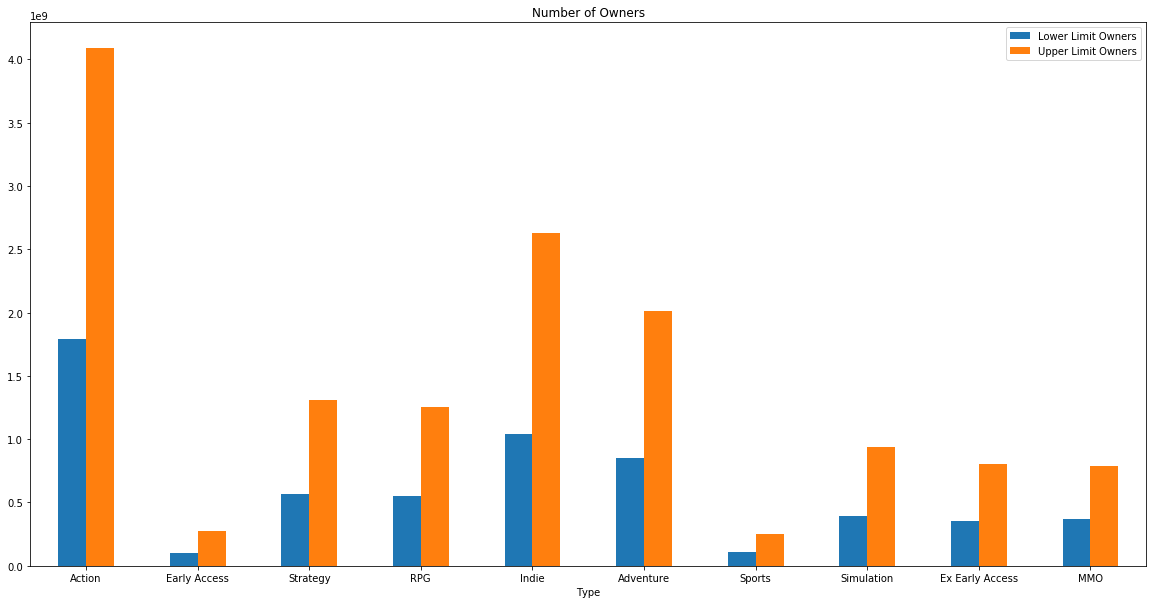

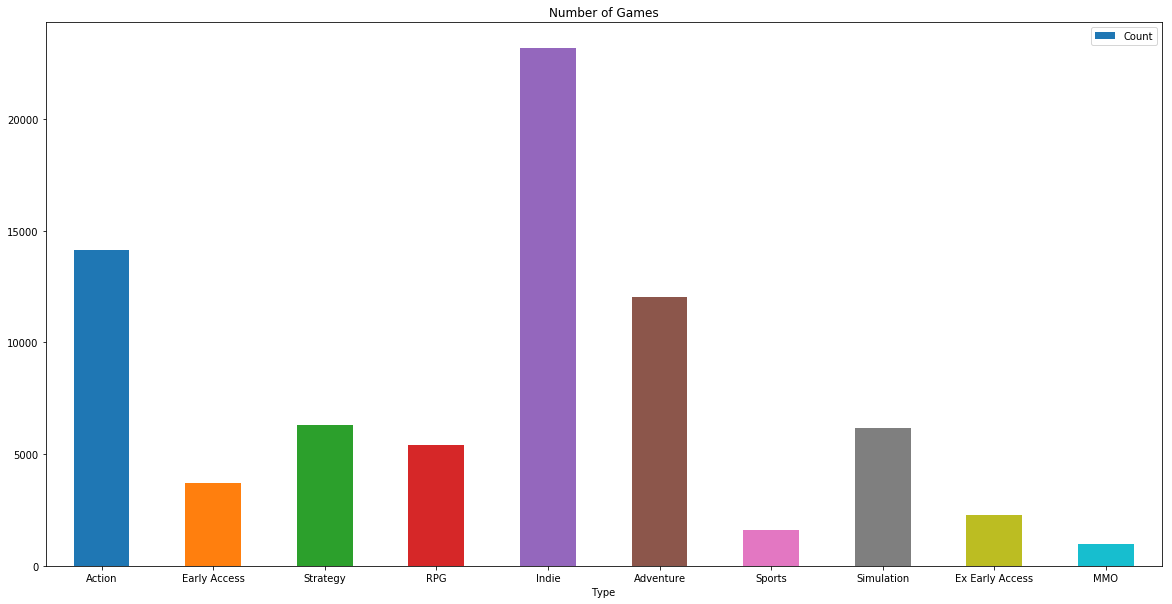

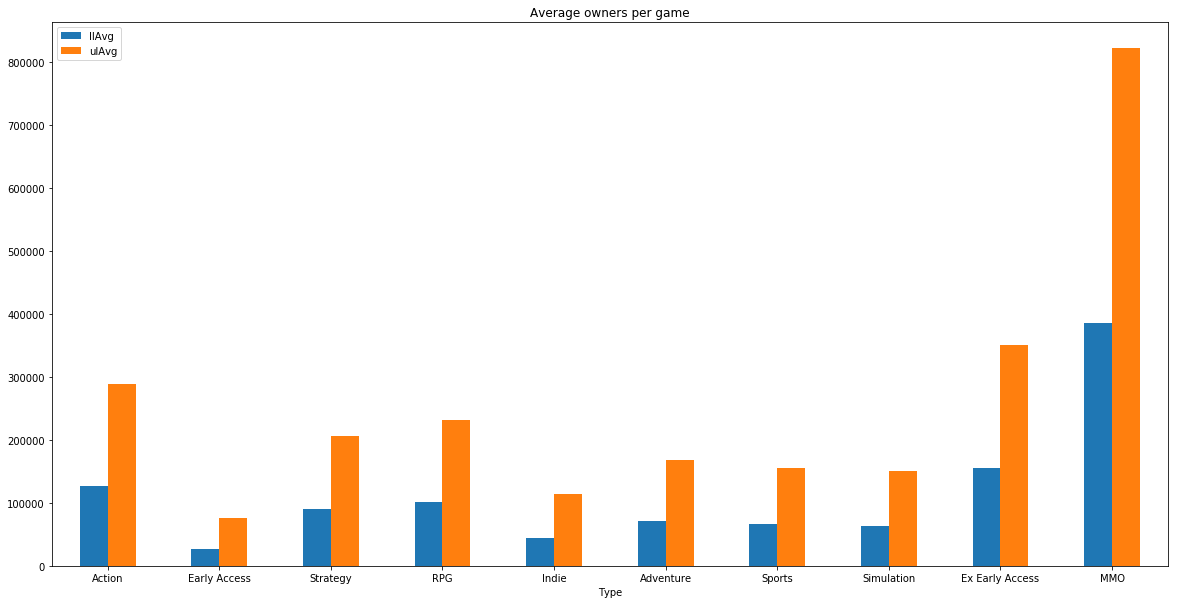

In [267]:
plotOwners(theGenres, genreNames)

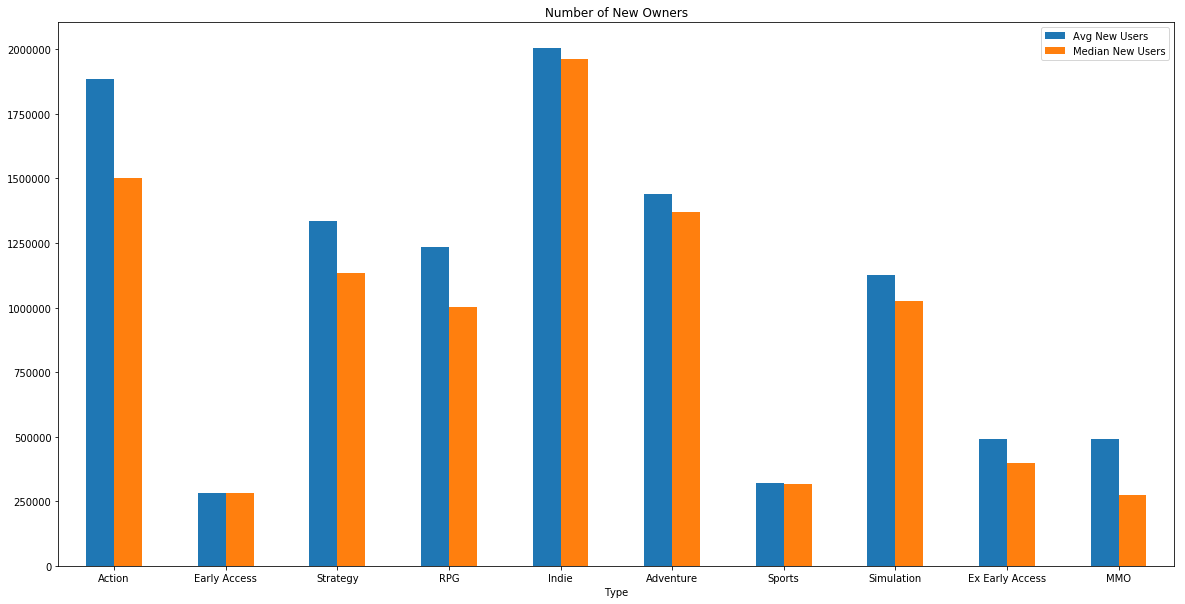

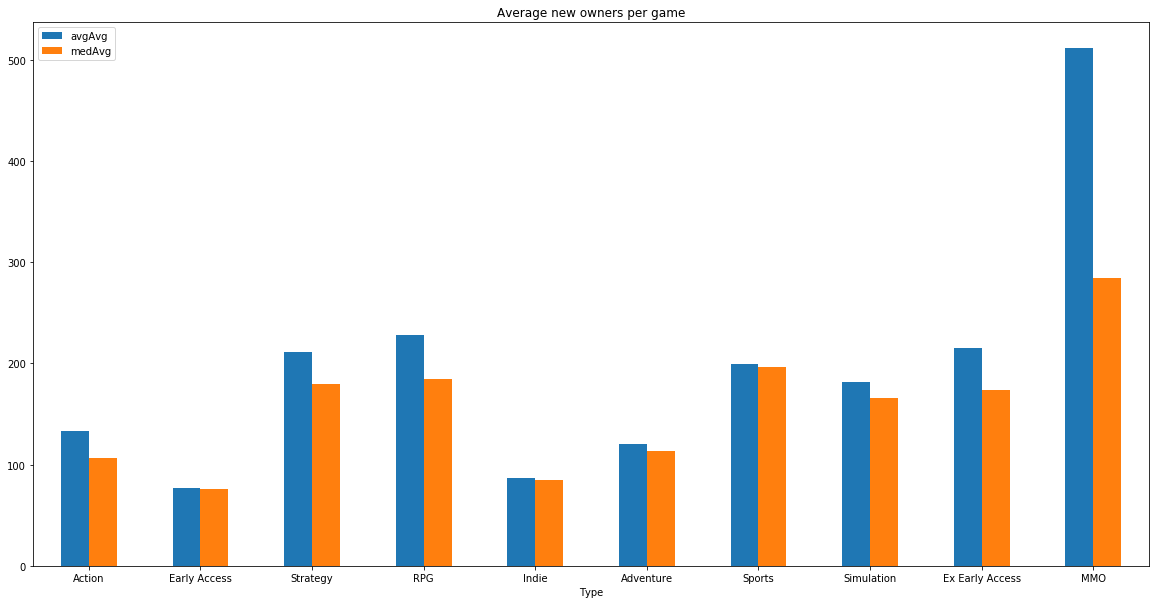

In [280]:
plotNewOwners(theGenres, genreNames)

In [ ]:
#making price column ints and making price of free games 0
data['price'] = data['price'].fillna(0)
data['price'] = data['price'].astype(int)

In [ ]:
data['negative'] = data['negative'].astype(int)
data['positive'] = data['positive'].astype(int)

In [ ]:
data['Like/Dislike Ratio'] = data['positive']/data['negative']

In [ ]:
paid10 = data[(data.price < 1001) & (data.price > 0)] #games between 0.01-10 dollars
paid20 = data[(data.price > 1000) & (data.price < 2001)]
paid30 = data[(data.price > 2000) & (data.price < 3001)]
paid40 = data[(data.price > 3000) & (data.price < 4001)]
paid50 = data[(data.price > 4000) & (data.price < 5001)]
paid60 = data[(data.price > 5000) & (data.price < 6001)]
paidOver60 = data[data.price > 6000]

In [ ]:
priceOfGame = [free, paid10, paid20, paid30, paid40, paid50, paid60, paidOver60]
priceNames = ['Free', 'Paid 10', 'Paid 20', 'Paid 30', 'Paid 40', 'Paid 50', 'Paid 60', 'Paid Over 60']

In [ ]:
dfPaid = createOwnersDF(priceOfGame, priceNames)

In [ ]:
#owners by price point without truncation
plotOwners(dfPaid)

In [ ]:
ordereddata = data.sort_values(by=['llOwners','ulOwners'], ascending=False)
truncatedData = ordereddata.iloc[20:]

In [ ]:
free = truncatedData[truncatedData.price == 0]
paid10 = truncatedData[(truncatedData.price < 1001) & (truncatedData.price > 0)] #games between 0.01-10 dollars
paid20 = truncatedData[(truncatedData.price > 1000) & (truncatedData.price < 2001)]
paid30 = truncatedData[(truncatedData.price > 2000) & (truncatedData.price < 3001)]
paid40 = truncatedData[(truncatedData.price > 3000) & (truncatedData.price < 4001)]
paid50 = truncatedData[(truncatedData.price > 4000) & (truncatedData.price < 5001)]
paid60 = truncatedData[(truncatedData.price > 5000) & (truncatedData.price < 6001)]
paidOver60 = truncatedData[truncatedData.price > 6000]

In [ ]:
#owners of price points without top 20
priceOfGame = [free, paid10, paid20, paid30, paid40, paid50, paid60, paidOver60]
priceNames = ['Free', 'Paid 10', 'Paid 20', 'Paid 30', 'Paid 40', 'Paid 50', 'Paid 60', 'Paid Over 60']
dfPaid = createOwnersDF(priceOfGame, priceNames)
plotOwners(dfPaid)

In [ ]:
action = data[data['Genres'].apply(lambda x: 'Action' in x)]
earlyAccess = data[data['Genres'].apply(lambda x: 'Early Access' in x)]
strategy = data[data['Genres'].apply(lambda x: 'Strategy' in x)]
rpg = data[data['Genres'].apply(lambda x: 'RPG' in x)]
indie = data[data['Genres'].apply(lambda x: 'Indie' in x)]
adventure = data[data['Genres'].apply(lambda x: 'Adventure' in x)]
sports = data[data['Genres'].apply(lambda x: 'Sports' in x)]
simulation = data[data['Genres'].apply(lambda x: 'Simulation' in x)]
exEarlyAccess = data[data['Genres'].apply(lambda x: 'Ex Early Access' in x)]
mmo = data[data['Genres'].apply(lambda x: 'MMO' in x)]

In [ ]:
theGenres = [action, earlyAccess, strategy, rpg, indie, adventure, sports, simulation, exEarlyAccess, mmo]
genreNames = ['Action', 'Early Access', 'Strategy', 'RPG', 'Indie', 'Adventure', 'Sports',
              'Simulation', 'Ex Early Access', 'MMO']

In [ ]:
dfGenres = createOwnersDF(theGenres, genreNames)

In [ ]:
#owners of genres for paid games
plotOwners(dfGenres)

In [ ]:
singleplayer = data[data['Tags'].apply(lambda x: 'Singleplayer' in x)]
multiplayer = data[data['Tags'].apply(lambda x: 'Multiplayer' in x)]

In [ ]:
numPlayer = [singleplayer, multiplayer]
namesOfType = ['Singleplayer', 'Multiplayer']
dfPlayer = createOwnersDF(numPlayer, namesOfType)

In [ ]:
#owners of singleplayer vs multiplayer
plotOwners(dfPlayer)

In [ ]:
casual = data[data['Tags'].apply(lambda x: 'Casual' in x)]
soundtrack = data[data['Tags'].apply(lambda x: 'Great+Soundtrack' in x)]
atmospheric = data[data['Tags'].apply(lambda x: 'Atmospheric' in x)]
twoD = data[data['Tags'].apply(lambda x: '2D' in x)]
puzzle = data[data['Tags'].apply(lambda x: 'Puzzle' in x)]
openWorld = data[data['Tags'].apply(lambda x: 'Open+World' in x)]
storyRich = data[data['Tags'].apply(lambda x: 'Story+Rich' in x)]
coop = data[data['Tags'].apply(lambda x: 'Co-op' in x)]
difficult = data[data['Tags'].apply(lambda x: 'Difficult' in x)]
shooter = data[data['Tags'].apply(lambda x: 'Shooter' in x)]
scifi = data[data['Tags'].apply(lambda x: 'Sci-fi' in x)]
firstPerson = data[data['Tags'].apply(lambda x: 'First-Person' in x)]
horror = data[data['Tags'].apply(lambda x: 'Horror' in x)]
vr = data[data['Tags'].apply(lambda x: 'VR' in x)]
anime = data[data['Tags'].apply(lambda x: 'Anime' in x)]
pixelGraphics = data[data['Tags'].apply(lambda x: 'Pixel+Graphics' in x)]
funny = data[data['Tags'].apply(lambda x: 'Funny' in x)]
fantasy = data[data['Tags'].apply(lambda x: 'Fantasy' in x)]
platformer = data[data['Tags'].apply(lambda x: 'Platformer' in x)]
femaleProtagonist = data[data['Tags'].apply(lambda x: 'Female+Protagonist' in x)]
fps = data[data['Tags'].apply(lambda x: 'FPS' in x)]
survival = data[data['Tags'].apply(lambda x: 'Survival' in x)]
gore = data[data['Tags'].apply(lambda x: 'Gore' in x)]
violent = data[data['Tags'].apply(lambda x: 'Violent' in x)]
sandbox = data[data['Tags'].apply(lambda x: 'Sandbox' in x)]
comedy = data[data['Tags'].apply(lambda x: 'Comedy' in x)]
arcade = data[data['Tags'].apply(lambda x: 'Arcade' in x)]
classic = data[data['Tags'].apply(lambda x: 'Classic' in x)]
nudity = data[data['Tags'].apply(lambda x: 'Nudity' in x)]
onlineCoop = data[data['Tags'].apply(lambda x: 'Online+Co-op' in x)]
tactical = data[data['Tags'].apply(lambda x: 'Tactical' in x)]
zombies = data[data['Tags'].apply(lambda x: 'Zombies' in x)]
teamBased = data[data['Tags'].apply(lambda x: 'Team-Based' in x)]
pve = data[data['Tags'].apply(lambda x: 'PvE' in x)]
pvp = data[data['Tags'].apply(lambda x: 'PvP' in x)]
war = data[data['Tags'].apply(lambda x: 'War' in x)]
controller = data[data['Tags'].apply(lambda x: 'Controller' in x)]

In [ ]:
tags = [casual, soundtrack, atmospheric, twoD, puzzle, openWorld, storyRich, coop, difficult, shooter, scifi,
       firstPerson, horror, vr, anime, pixelGraphics, funny, fantasy, platformer, femaleProtagonist, fps, 
       survival, gore, violent, sandbox, comedy, arcade, classic, nudity, onlineCoop, tactical, zombies, teamBased,
       pve, pvp, war, controller]
tagNames = ['Casual', 'Great Soundtrack', 'Atmospheric', '2D', 'Puzzle', 'Open World', 'Story Rich', 'Co-op',
           'Difficult', 'Shooter', 'Sci-fi', 'First-Person', 'Horror', 'VR', 'Anime', 'Pixel Graphics', 'Funny',
           'Fantasy', 'Platformer', 'Female Protagonist', 'FPS', 'Survival', 'Gore', 'Violent', 'Sandbox', 'Comedy',
           'Arcade', 'Classic', 'Nudity', 'Online Co-op', 'Tactical', 'Zombies', 'Team-Based', 'PvE', 'PvP', 'War',
           'Controller']

In [ ]:
dfTags = createOwnersDF(tags, tagNames)

In [ ]:
#owners of tags
plotOwners(dfTags, 90)

In [ ]:
paid10 = data[(data.price < 1001) & (data.price > 0) & (data.llOwners < 10000000)] #games between 0.01-10 dollars
paid20 = data[(data.price > 1000) & (data.price < 2001) & (data.llOwners < 10000000)]
paid30 = data[(data.price > 2000) & (data.price < 3001) & (data.llOwners < 10000000)]
paid40 = data[(data.price > 3000) & (data.price < 4001) & (data.llOwners < 10000000)]
paid50 = data[(data.price > 4000) & (data.price < 5001) & (data.llOwners < 10000000)]
paid60 = data[(data.price > 5000) & (data.price < 6001) & (data.llOwners < 10000000)]
paidOver60 = data[(data.price > 6000) & (data.llOwners < 10000000)]
free = data[(data.price == 0) & (data.llOwners < 10000000)]
priceOfGame = [paid10, paid20, paid30, paid40, paid50, paid60, paidOver60, free]

In [ ]:
#likedislike vs owners
fig, ax = plt.subplots(figsize=(20,10))
for pricepoint in priceOfGame:
    ax.scatter(pricepoint['llOwners'], pricepoint['Like/Dislike Ratio'], alpha=0.6)
ax.legend(('10', '20', '30', '40', '50', '60', '>60', 'free'))

In [ ]:
priceOfGame = [paid10, paid20, paid30, paid40, paid50, paid60, paidOver60]
#likedislike vs owners without free games
fig, ax = plt.subplots(figsize=(20,10))
for pricepoint in priceOfGame:
    ax.scatter(pricepoint['llOwners'], pricepoint['Like/Dislike Ratio'], alpha=0.6)
ax.legend(('10', '20', '30', '40', '50', '60', '>60'))

In [ ]:
paid10 = data[(data.price < 1001) & (data.price > 0) & (data.average_forever < 10000)] #games between 0.01-10 dollars
paid20 = data[(data.price > 1000) & (data.price < 2001) & (data.average_forever < 10000)]
paid30 = data[(data.price > 2000) & (data.price < 3001) & (data.average_forever < 10000)]
paid40 = data[(data.price > 3000) & (data.price < 4001) & (data.average_forever < 10000)]
paid50 = data[(data.price > 4000) & (data.price < 5001) & (data.average_forever < 10000)]
paid60 = data[(data.price > 5000) & (data.price < 6001) & (data.average_forever < 10000)]
paidOver60 = data[(data.price > 6000) & (data.average_forever < 10000)]
free = data[(data.price == 0) & (data.average_forever < 10000)]
priceOfGame = [paid10, paid20, paid30, paid40, paid50, paid60, paidOver60, free]

In [ ]:
#average new oners by price point
fig, ax = plt.subplots(figsize=(20,10))
for pricepoint in priceOfGame:
    ax.scatter(pricepoint['average_forever'], pricepoint['Like/Dislike Ratio'], alpha=0.5)
ax.legend(('10', '20', '30', '40', '50', '60', '>60', 'free'))

In [ ]:
priceOfGame = [paid10, paid20, paid30, paid40, paid50, paid60, paidOver60]
#average new oners by price point without free
fig, ax = plt.subplots(figsize=(20,10))
for pricepoint in priceOfGame:
    ax.scatter(pricepoint['average_forever'], pricepoint['Like/Dislike Ratio'], alpha=0.5)
ax.legend(('10', '20', '30', '40', '50', '60', '>60'))

In [ ]:
paid20 = data[(data.price < 2001) & (data.price > 0) & (data.average_forever < 10000)] #games between 0.01-10 dollars
paid40 = data[(data.price > 2000) & (data.price < 4001) & (data.average_forever < 10000)]
paid60 = data[(data.price > 4000) & (data.price < 6001) & (data.average_forever < 10000)]
paidOver60 = data[(data.price > 6000) & (data.average_forever < 10000)]
free = data[(data.price == 0) & (data.average_forever < 10000)]
priceOfGame = [paid20, paid40, paid60, paidOver60, free]

In [ ]:
#average new oners by price point with larger price intervals
fig, ax = plt.subplots(figsize=(20,10))
for pricepoint in priceOfGame:
    ax.scatter(pricepoint['average_forever'], pricepoint['Like/Dislike Ratio'], alpha=0.5)
ax.legend(('20', '40', '60', '>60', 'free'))

In [ ]:
priceOfGame = [paid20, paid40, paid60, paidOver60]
#average new oners by price point with larger price intervals without free
fig, ax = plt.subplots(figsize=(20,10))
for pricepoint in priceOfGame:
    ax.scatter(pricepoint['average_forever'], pricepoint['Like/Dislike Ratio'], alpha=0.5)
ax.legend(('20', '40', '60', '>60'))

In [198]:
#splitting data into free and paid
indie = data[data['Genres'].apply(lambda x: 'Indie' in x)]
notIndie = data[data['Genres'].apply(lambda x: 'Indie' not in x)]
dataFree = notIndie[notIndie.price == 0]
dataPaid = notIndie[notIndie.price != 0]
dataFreeIndie = indie[indie.price == 0]
dataPaidIndie = indie[indie.price != 0]

In [229]:
action = dataFree[dataFree['Genres'].apply(lambda x: 'Action' in x)]
#earlyAccess = dataFree[dataFree['Genres'].apply(lambda x: 'Early Access' in x)]
strategy = dataFree[dataFree['Genres'].apply(lambda x: 'Strategy' in x)]
rpg = dataFree[dataFree['Genres'].apply(lambda x: 'RPG' in x)]
#indie = dataFree[dataFree['Genres'].apply(lambda x: 'Indie' in x)]
adventure = dataFree[dataFree['Genres'].apply(lambda x: 'Adventure' in x)]
sports = dataFree[dataFree['Genres'].apply(lambda x: 'Sports' in x)]
simulation = dataFree[dataFree['Genres'].apply(lambda x: 'Simulation' in x)]
#exEarlyAccess = dataFree[dataFree['Genres'].apply(lambda x: 'Ex Early Access' in x)]
mmo = dataFree[dataFree['Genres'].apply(lambda x: 'MMO' in x)]
# theGenres = [action, earlyAccess, strategy, rpg, indie, adventure, sports, simulation, exEarlyAccess, mmo]
# genreNames = ['Action', 'Early Access', 'Strategy', 'RPG', 'Indie', 'Adventure', 'Sports',
#               'Simulation', 'Ex Early Access', 'MMO']
theGenres = [action, strategy, rpg, adventure, sports, simulation, mmo]
genreNames = ['Action', 'Strategy', 'RPG', 'Adventure', 'Sports',
              'Simulation', 'MMO']
dfGenres = createOwnersDF(theGenres, genreNames)

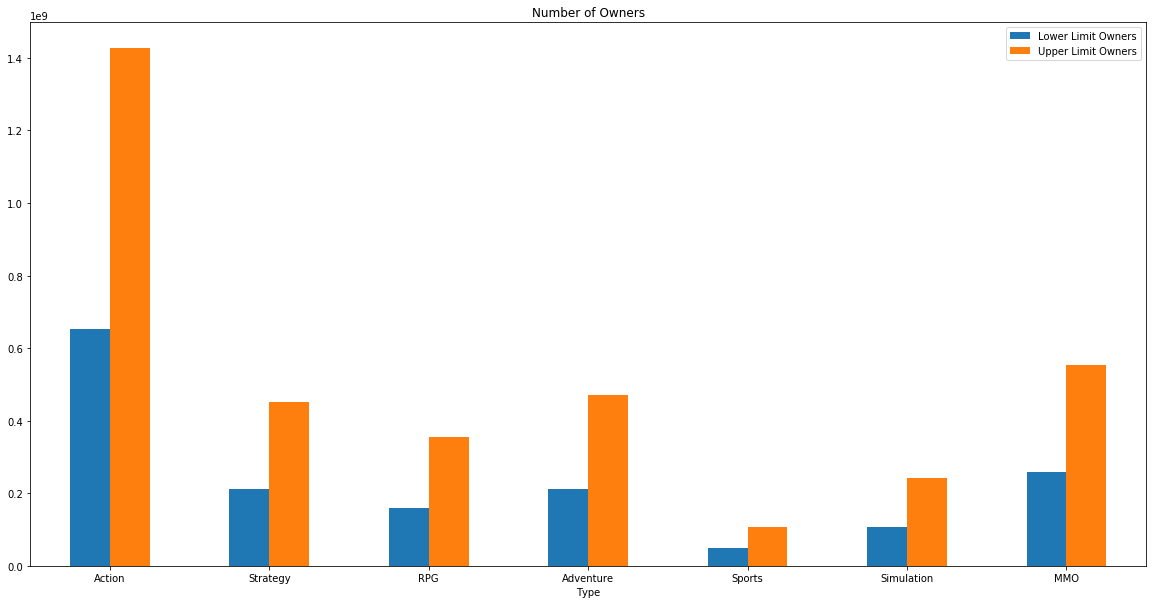

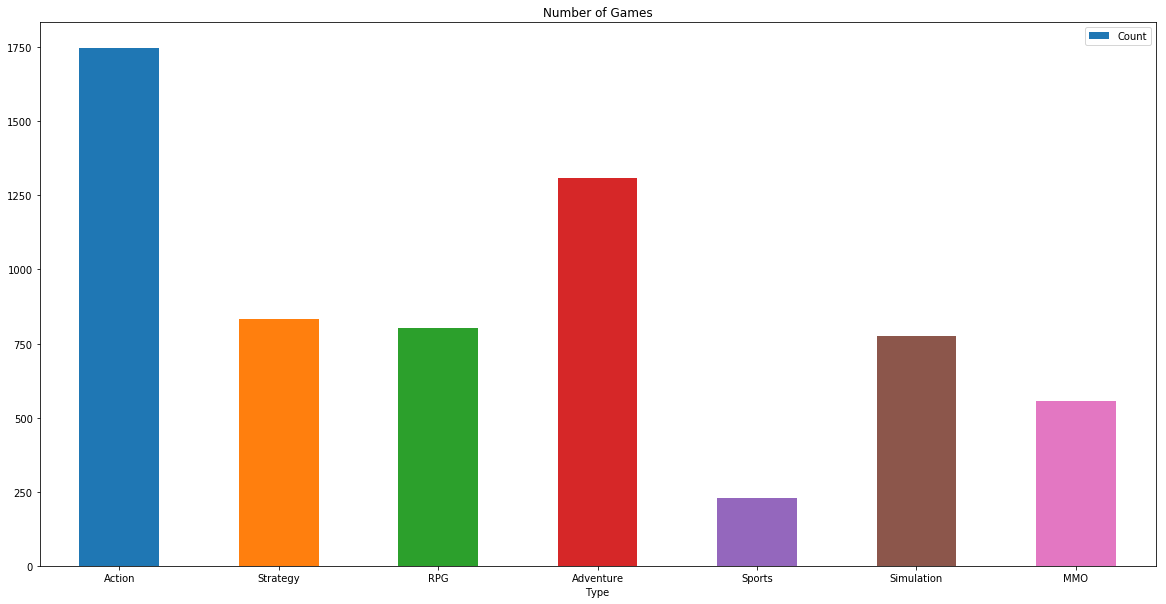

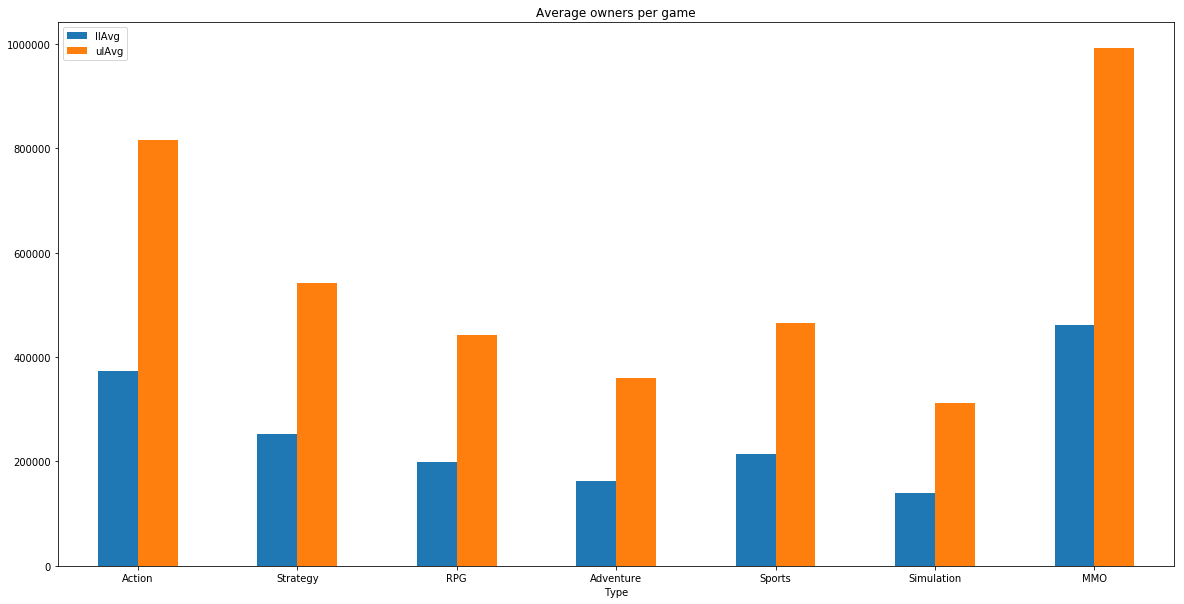

In [230]:
#owners of genres for free games
plotOwners(dfGenres)

Text(0.5, 1.0, 'Average New Owners vs Like/Dislike Ratio for free games')

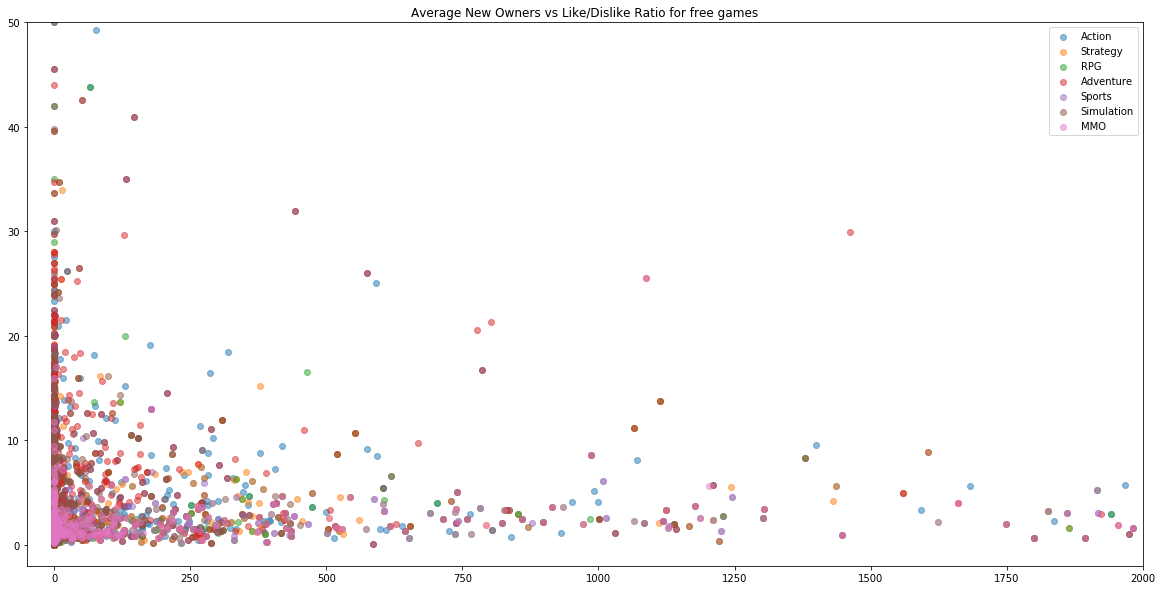

In [240]:
#average new owners vs like/dislike for free
fig, ax = plt.subplots(figsize=(20,10))
for genre in theGenres:
    ax.scatter(genre['average_forever'], genre['Like/Dislike Ratio'], alpha=0.5)
plt.xlim(-50, 2000)
plt.ylim(-2, 50)
ax.legend(genreNames)
ax.set_title("Average New Owners vs Like/Dislike Ratio for free games")

In [246]:
theGenres = [action, mmo]
genreNames = ['Action', 'MMO']

Text(0.5, 1.0, 'Average New Owners vs Like/Dislike Ratio for free games')

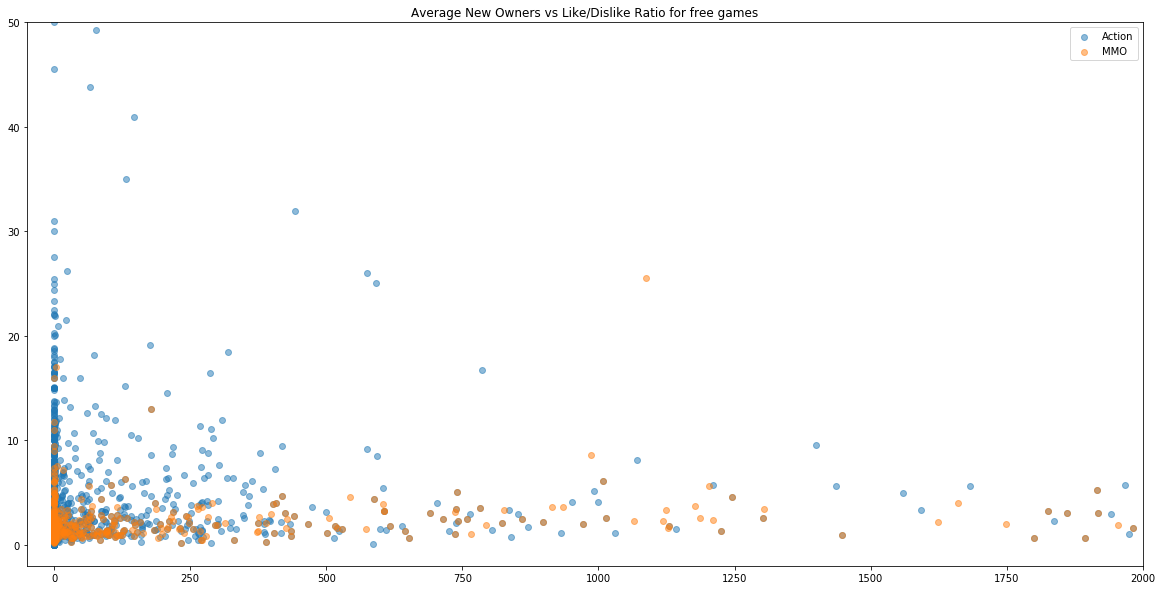

In [248]:
#average new owners vs like/dislike for free
fig, ax = plt.subplots(figsize=(20,10))
for genre in theGenres:
    ax.scatter(genre['average_forever'], genre['Like/Dislike Ratio'], alpha=0.5)
plt.xlim(-50, 2000)
plt.ylim(-2, 50)
ax.legend(genreNames)
ax.set_title("Average New Owners vs Like/Dislike Ratio for free games")

Text(0.5, 1.0, 'Average New Owners vs Like/Dislike Ratio for free games')

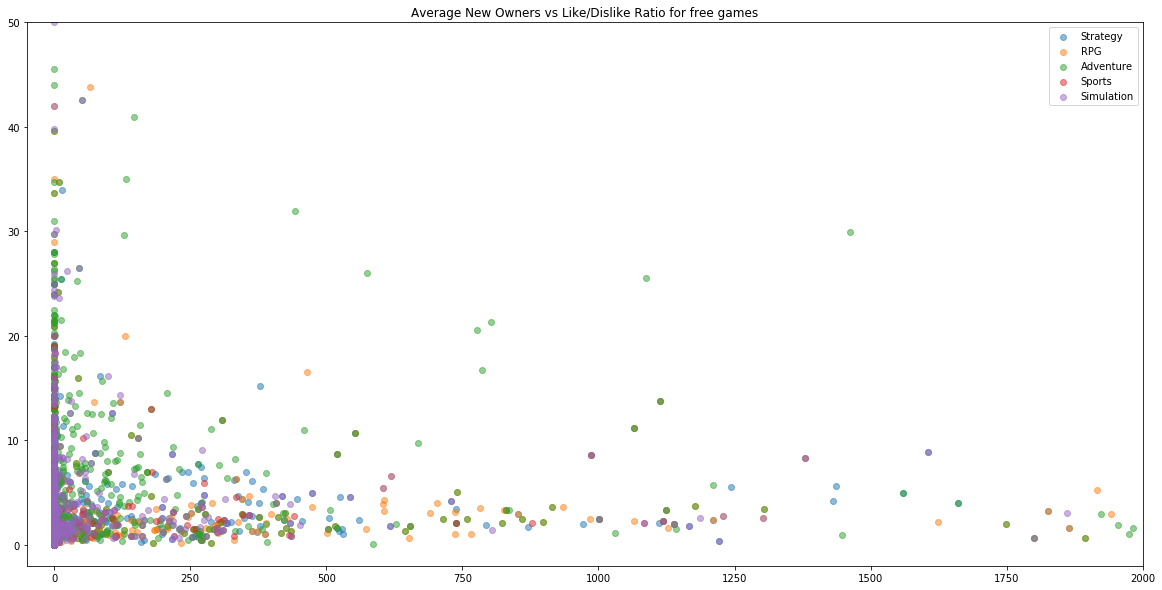

In [253]:
theGenres = [strategy, rpg, adventure, sports, simulation]
genreNames = ['Strategy', 'RPG', 'Adventure', 'Sports', 'Simulation']
#average new owners vs like/dislike for free
fig, ax = plt.subplots(figsize=(20,10))
for genre in theGenres:
    ax.scatter(genre['average_forever'], genre['Like/Dislike Ratio'], alpha=0.5)
plt.xlim(-50, 2000)
plt.ylim(-2, 50)
ax.legend(genreNames)
ax.set_title("Average New Owners vs Like/Dislike Ratio for free games")

Text(0.5, 1.0, 'Average New Owners vs Like/Dislike Ratio for free games')

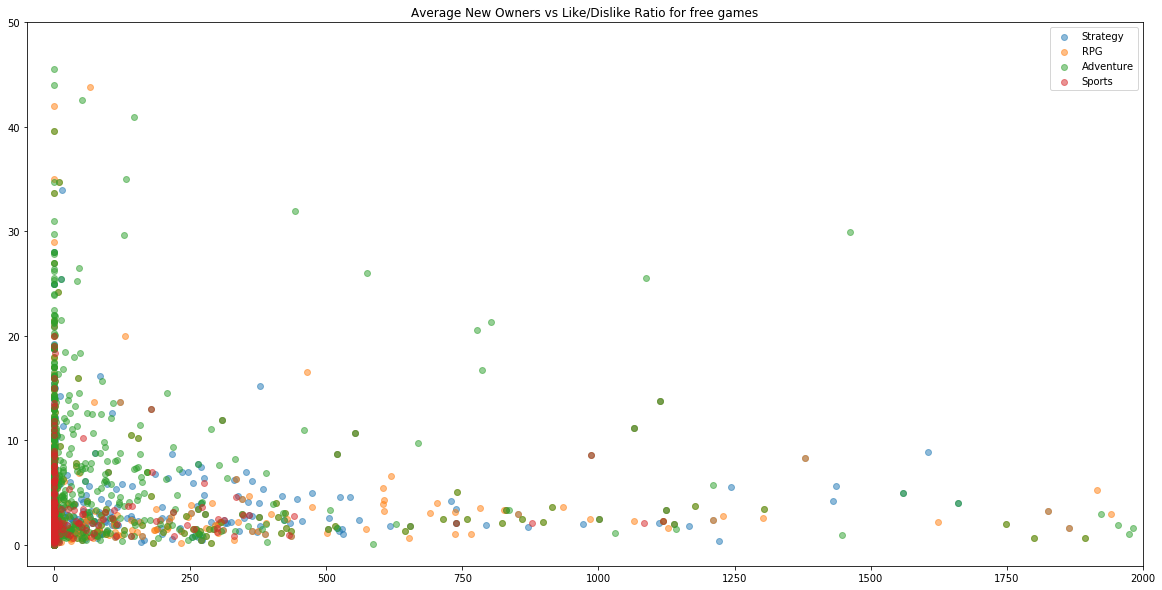

In [254]:
theGenres = [strategy, rpg, adventure, sports]
genreNames = ['Strategy', 'RPG', 'Adventure', 'Sports']
#average new owners vs like/dislike for free
fig, ax = plt.subplots(figsize=(20,10))
for genre in theGenres:
    ax.scatter(genre['average_forever'], genre['Like/Dislike Ratio'], alpha=0.5)
plt.xlim(-50, 2000)
plt.ylim(-2, 50)
ax.legend(genreNames)
ax.set_title("Average New Owners vs Like/Dislike Ratio for free games")

Text(0.5, 1.0, 'Average New Owners vs Like/Dislike Ratio for free games')

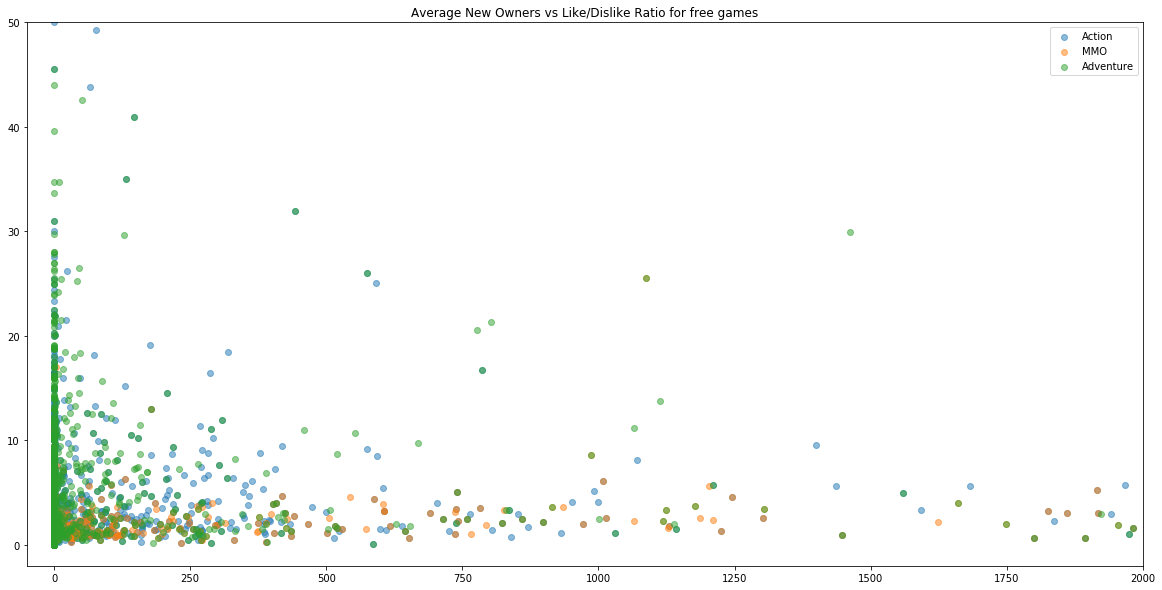

In [255]:
theGenres = [action, mmo, adventure]
genreNames = ['Action', 'MMO', 'Adventure']
#average new owners vs like/dislike for free
fig, ax = plt.subplots(figsize=(20,10))
for genre in theGenres:
    ax.scatter(genre['average_forever'], genre['Like/Dislike Ratio'], alpha=0.5)
plt.xlim(-50, 2000)
plt.ylim(-2, 50)
ax.legend(genreNames)
ax.set_title("Average New Owners vs Like/Dislike Ratio for free games")

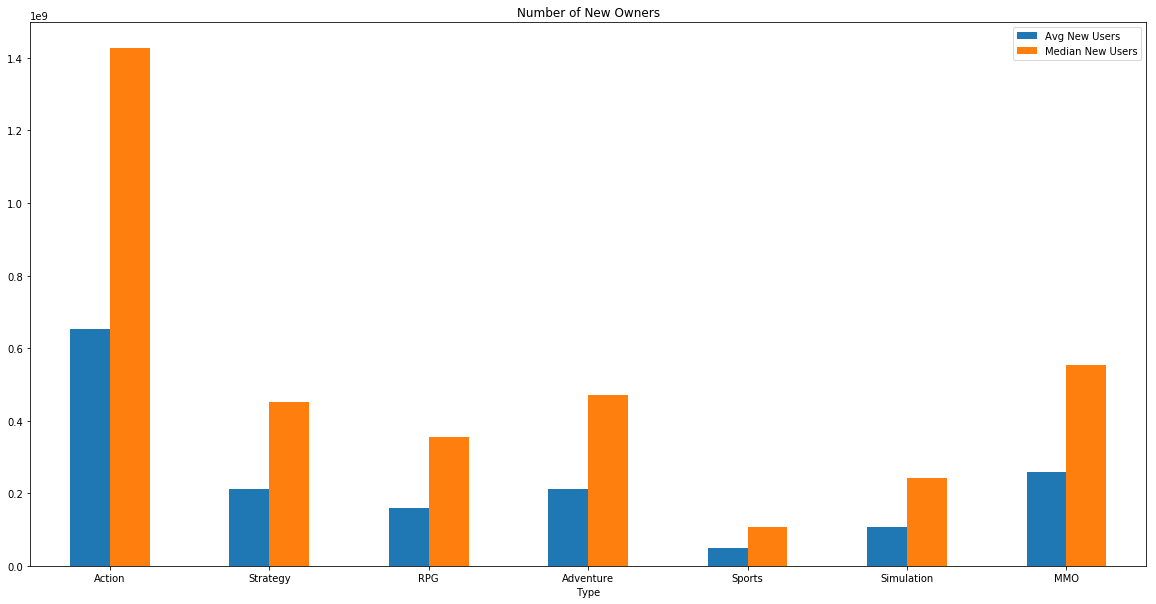

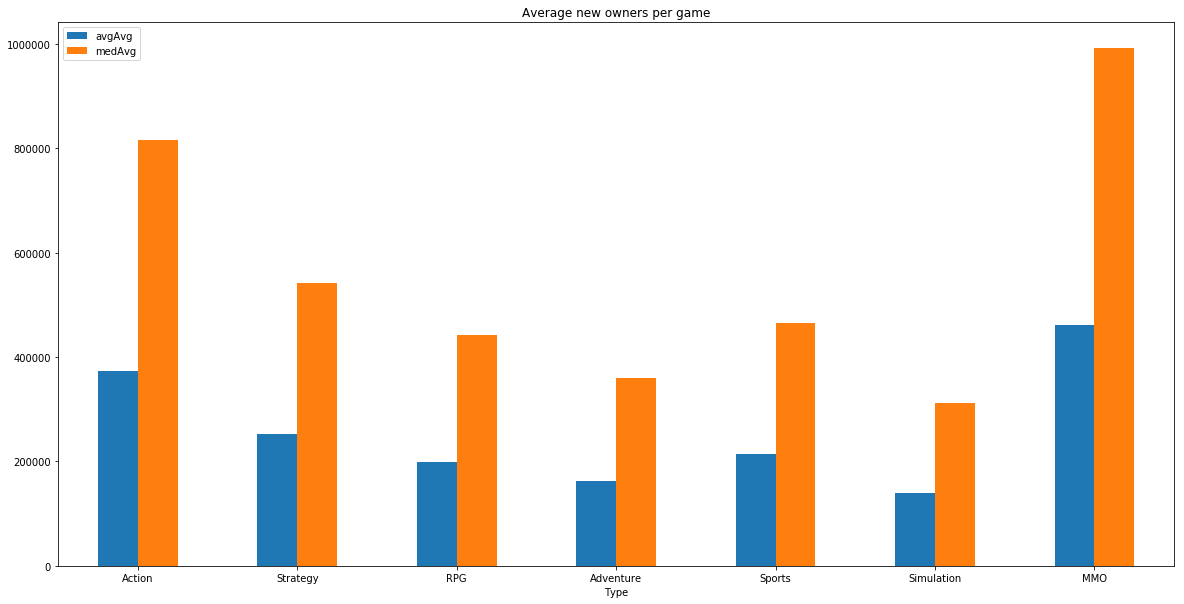

In [241]:
plotNewOwners(theGenres, genreNames) #new owners by genre for paid

In [256]:
action = dataPaid[dataPaid['Genres'].apply(lambda x: 'Action' in x)]
#earlyAccess = dataPaid[dataPaid['Genres'].apply(lambda x: 'Early Access' in x)]
strategy = dataPaid[dataPaid['Genres'].apply(lambda x: 'Strategy' in x)]
rpg = dataPaid[dataPaid['Genres'].apply(lambda x: 'RPG' in x)]
#indie = dataPaid[dataPaid['Genres'].apply(lambda x: 'Indie' in x)]
adventure = dataPaid[dataPaid['Genres'].apply(lambda x: 'Adventure' in x)]
sports = dataPaid[dataPaid['Genres'].apply(lambda x: 'Sports' in x)]
simulation = dataPaid[dataPaid['Genres'].apply(lambda x: 'Simulation' in x)]
#exEarlyAccess = dataPaid[dataPaid['Genres'].apply(lambda x: 'Ex Early Access' in x)]
mmo = dataPaid[dataPaid['Genres'].apply(lambda x: 'MMO' in x)]
# theGenres = [action, earlyAccess, strategy, rpg, indie, adventure, sports, simulation, exEarlyAccess, mmo]
# genreNames = ['Action', 'Early Access', 'Strategy', 'RPG', 'Indie', 'Adventure', 'Sports',
#               'Simulation', 'Ex Early Access', 'MMO']
theGenres = [action, strategy, rpg, adventure, sports, simulation, mmo]
genreNames = ['Action', 'Strategy', 'RPG', 'Adventure', 'Sports',
              'Simulation', 'MMO']
dfGenres = createOwnersDF(theGenres, genreNames)

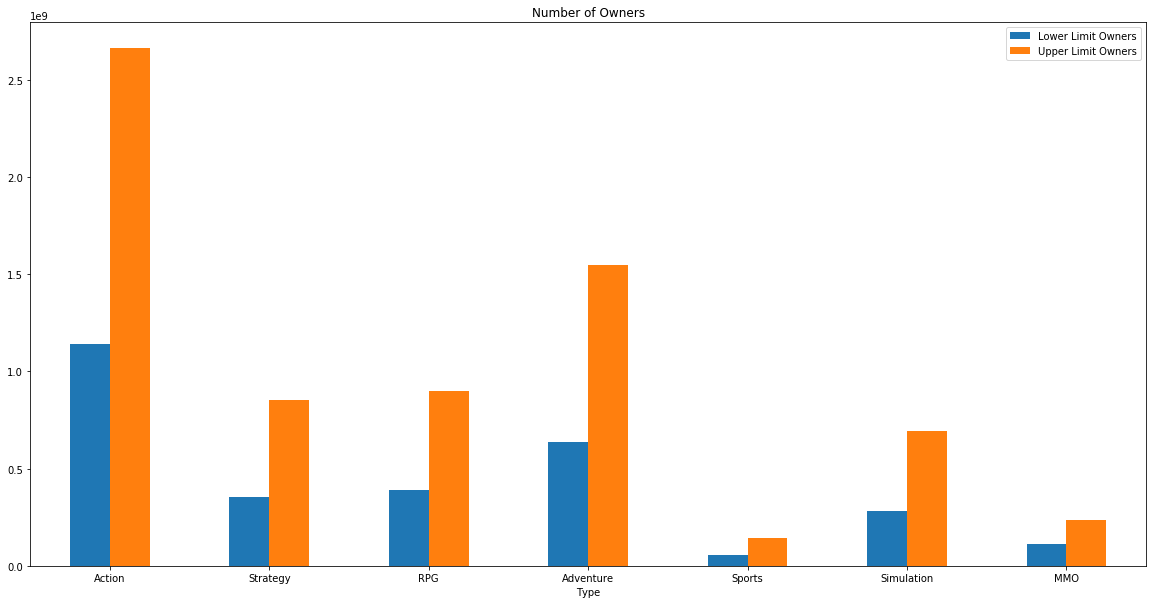

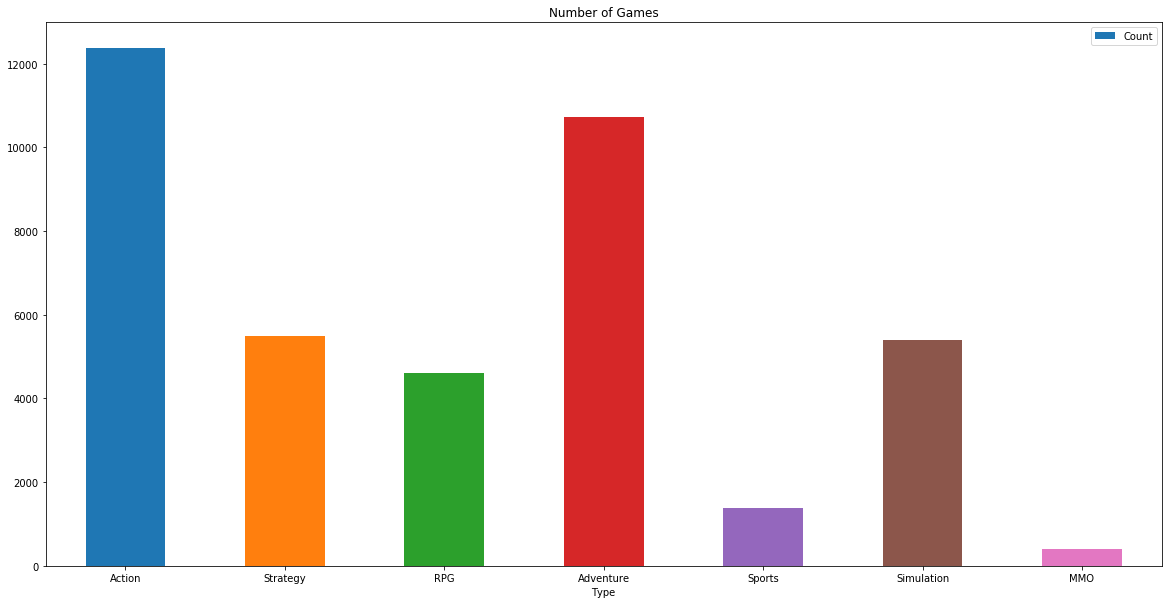

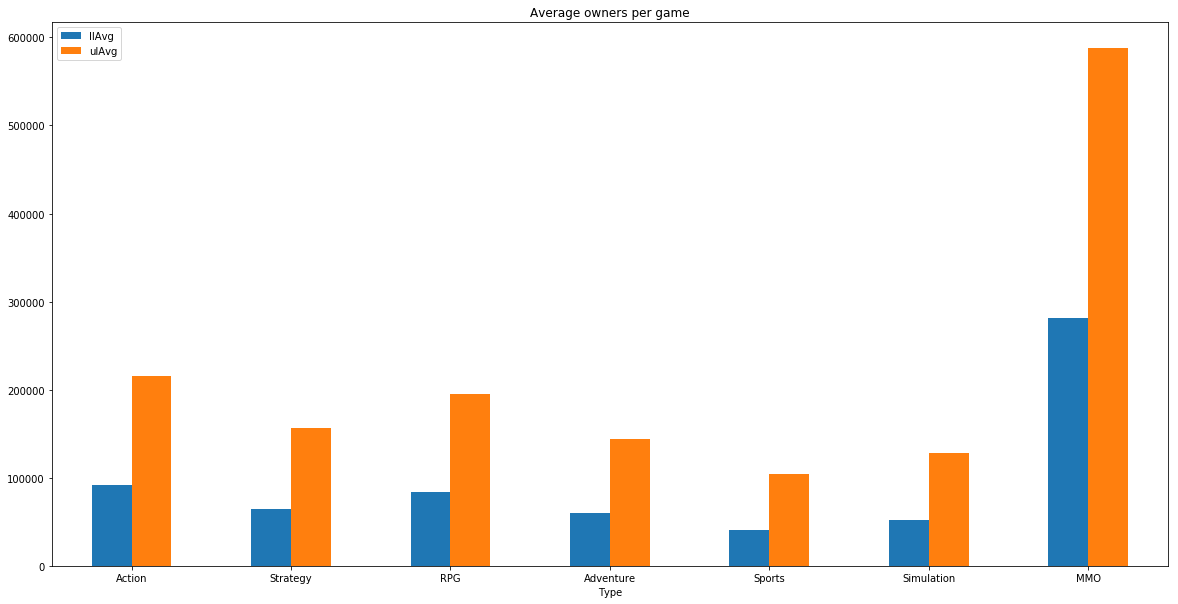

In [217]:
#owners of genres for paid games
plotOwners(dfGenres)

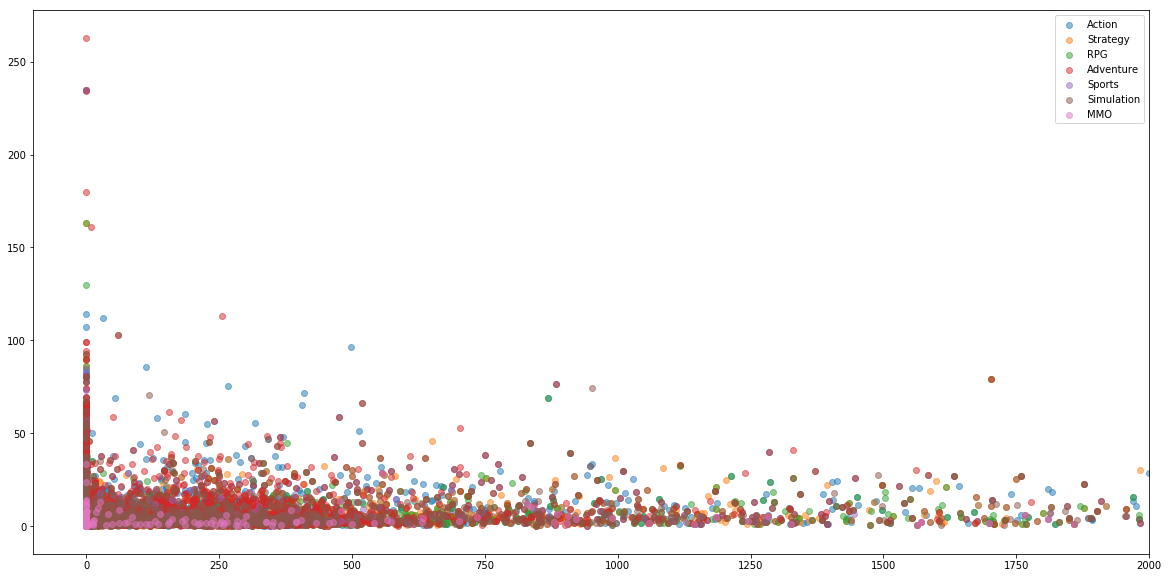

In [219]:
#average new owners vs like/dislike
fig, ax = plt.subplots(figsize=(20,10))
for genre in theGenres:
    ax.scatter(genre['average_forever'], genre['Like/Dislike Ratio'], alpha=0.5)
plt.xlim(-100, 2000)
ax.legend(genreNames)
ax.set_title("Average New Owners vs Like/Dislike Ratio for Paid Games")

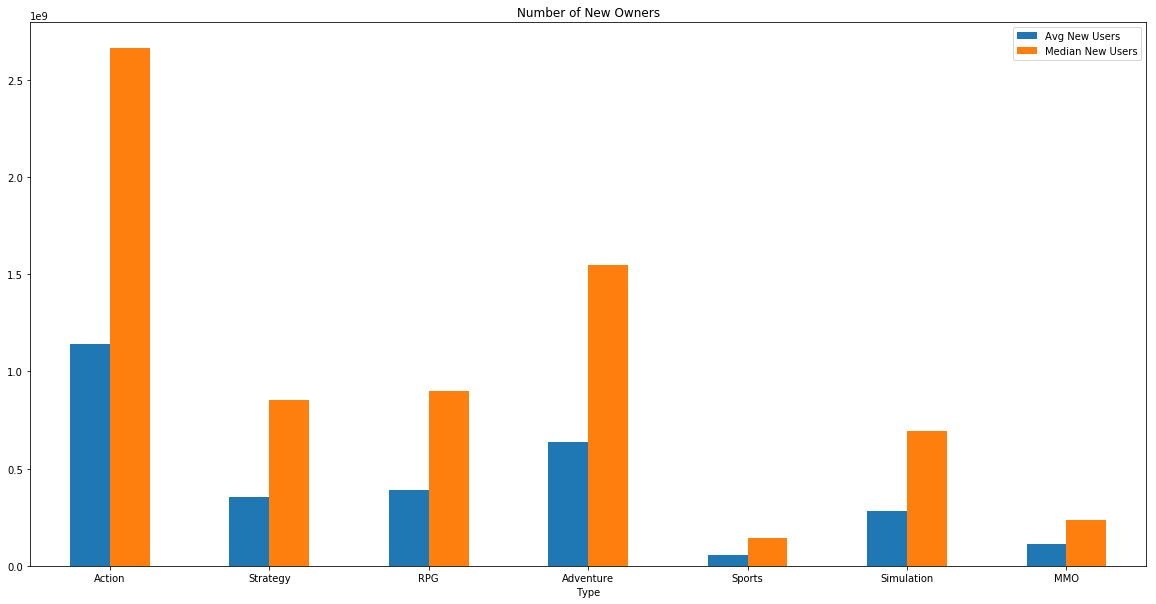

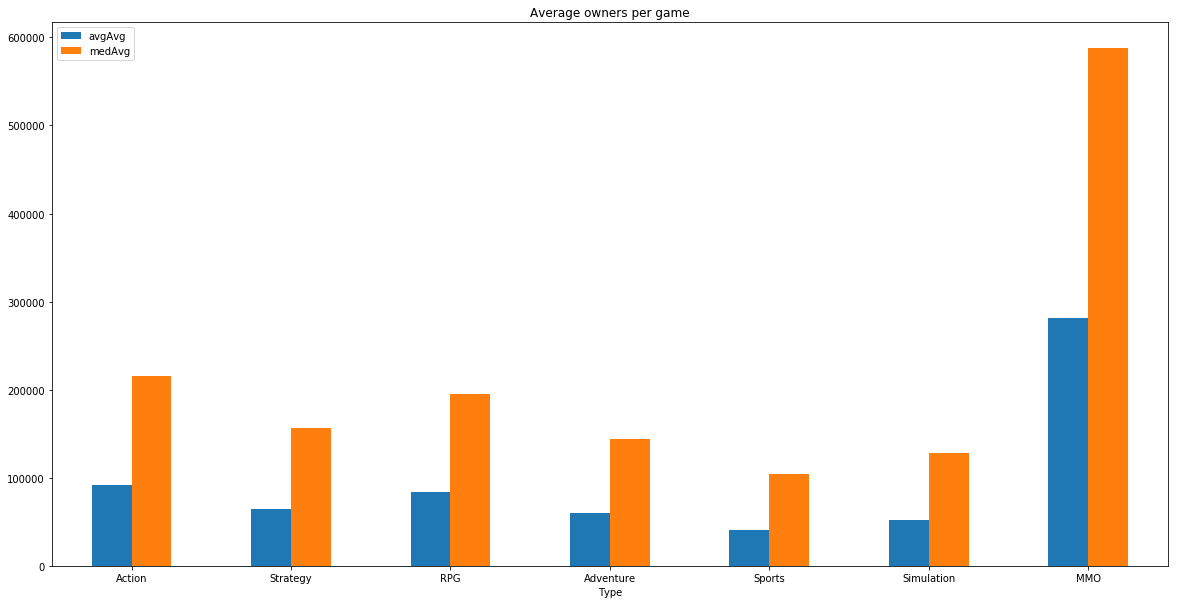

In [227]:
plotNewOwners(theGenres, genreNames) #new owners by genre for paid